In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [2]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

BES_R_data_files = BES_data_folder + "R_data" + os.sep
if not os.path.exists( BES_R_data_files ):
    os.makedirs( BES_R_data_files )


In [3]:
dataset_name = "W8_only"

In [4]:
%%time

manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

dataset_filename = manifest["Stata_Filename"].values[0]
# dataset_description = manifest["Friendlier_Description"].values[0]
# dataset_citation = manifest["Citation"].values[0]
# dataset_start = manifest["Date_Start"].values[0]
# dataset_stop = manifest["Date_Stop"].values[0]
# dataset_wave = manifest["Wave No"].values[0]

# BES_Panel = pd.read_stata( data_subfolder + dataset_filename )
BES_Panel  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
print("BES_Panel", BES_Panel.shape )

BES_Panel (33502, 455)
Wall time: 517 ms


In [5]:
%%time

BES_numeric = pd.read_hdf( data_subfolder + "BESnumeric.hdf", "BESnumeric" )
print("BES_numeric",  BES_numeric.shape )

var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
var_type.set_index("Unnamed: 0", inplace=True)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
    
####

BES_non_numeric = pd.read_hdf( data_subfolder + "BESnon_numeric.hdf", "BESnon_numeric" )
print("BES_non_numeric",  BES_non_numeric.shape )

BES_reduced = pd.read_hdf( data_subfolder + "BES_reduced.hdf", "BES_reduced" )
print("BES_reduced",  BES_reduced.shape )

BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
print("BES_reduced_with_na", BES_reduced_with_na.shape )

fname = data_subfolder + "new_old_col_names.pkl"
with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f) 

BES_numeric (33502, 399)
var_type (455, 13)
BES_non_numeric (33502, 51)
BES_reduced (33502, 351)
BES_reduced_with_na (33502, 351)
Wall time: 1.52 s


In [6]:
import tensorflow as tf
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping

In [7]:
# warnings - don't know why, online comments suggest just blocking
tf.logging.set_verbosity(tf.logging.ERROR)

In [8]:
# [x for x in BES_reduced.columns if "euref" in x.lower()]
y = BES_reduced['euRefVote_Leave the EU'].values
X = BES_reduced.drop(['euRefVote_Leave the EU'],axis=1).values

In [9]:
from tensorflow.python.keras.utils import to_categorical
y = to_categorical(y)

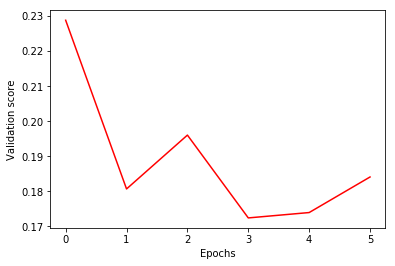

In [10]:
#
early_stopping_monitor = EarlyStopping(patience=2)

# Create the model: model
model = Sequential()

# Add the first hidden layer
input_shape = (X.shape[1],)
model.add( Dense(50, activation='relu', input_shape = input_shape) )

# Add the second hidden layer
model.add( Dense(50, activation='relu') )

# Add the output layer
no_of_outputs = len(np.unique(y))
model.add( Dense( no_of_outputs , activation='softmax') )

# Compile the model
model.compile( optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Fit the model
model_training = model.fit(X, y, epochs=15, validation_split=0.2, callbacks=[early_stopping_monitor], verbose=False)

# Create the plot
plt.plot(model_training.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

In [15]:
import shap
from shap.explainers.deep import DeepExplainer
e = DeepExplainer(model,X)

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\shap\explainers\deep.py:79: UserWarning: Your TensorFlow version is older than 1.8.0 and not supported.
  warnings.warn("Your TensorFlow version is older than 1.8.0 and not supported.")


TypeError: get_backward_walk_ops() got an unexpected keyword argument 'within_ops_fn'

In [11]:
tf.__version__

'1.5.1'

In [50]:
## Deep learning has install issues! Going to create a new environment just for tensorflow

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding 5 connected components using meta-embedding (experimental)
  n_components


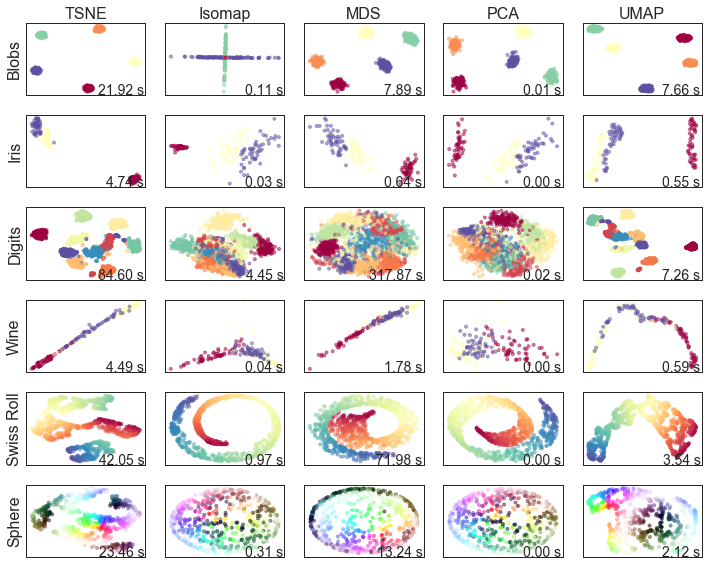

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn import datasets, decomposition, manifold, preprocessing
from colorsys import hsv_to_rgb

import umap

sns.set(context="paper", style="white")

blobs, blob_labels = datasets.make_blobs(
    n_samples=500, n_features=10, centers=5, random_state=42
)
iris = datasets.load_iris()
digits = datasets.load_digits(n_class=10)
wine = datasets.load_wine()
swissroll, swissroll_labels = datasets.make_swiss_roll(
    n_samples=1000, noise=0.1, random_state=42
)
sphere = np.random.normal(size=(600, 3))
sphere = preprocessing.normalize(sphere)
sphere_hsv = np.array(
    [
        (
            (np.arctan2(c[1], c[0]) + np.pi) / (2 * np.pi),
            np.abs(c[2]),
            min((c[2] + 1.1), 1.0),
        )
        for c in sphere
    ]
)
sphere_colors = np.array([hsv_to_rgb(*c) for c in sphere_hsv])

reducers = [
    (manifold.TSNE, {"perplexity": 50}),
    # (manifold.LocallyLinearEmbedding, {'n_neighbors':10, 'method':'hessian'}),
    (manifold.Isomap, {"n_neighbors": 30}),
    (manifold.MDS, {}),
    (decomposition.PCA, {}),
    (umap.UMAP, {"n_neighbors": 30, "min_dist": 0.3}),
]

test_data = [
    (blobs, blob_labels),
    (iris.data, iris.target),
    (digits.data, digits.target),
    (wine.data, wine.target),
    (swissroll, swissroll_labels),
    (sphere, sphere_colors),
]
dataset_names = ["Blobs", "Iris", "Digits", "Wine", "Swiss Roll", "Sphere"]

n_rows = len(test_data)
n_cols = len(reducers)
ax_index = 1
ax_list = []

# plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.figure(figsize=(10, 8))
plt.subplots_adjust(
    left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01
)
for data, labels in test_data:
    for reducer, args in reducers:
        start_time = time.time()
        embedding = reducer(n_components=2, **args).fit_transform(data)
        elapsed_time = time.time() - start_time
        ax = plt.subplot(n_rows, n_cols, ax_index)
        if isinstance(labels[0], tuple):
            ax.scatter(*embedding.T, s=10, c=labels, alpha=0.5)
        else:
            ax.scatter(
                *embedding.T, s=10, c=labels, cmap="Spectral", alpha=0.5
            )
        ax.text(
            0.99,
            0.01,
            "{:.2f} s".format(elapsed_time),
            transform=ax.transAxes,
            size=14,
            horizontalalignment="right",
        )
        ax_list.append(ax)
        ax_index += 1
plt.setp(ax_list, xticks=[], yticks=[])

for i in np.arange(n_rows) * n_cols:
    ax_list[i].set_ylabel(dataset_names[i // n_cols], size=16)
for i in range(n_cols):
    ax_list[i].set_xlabel(repr(reducers[i][0]()).split("(")[0], size=16)
    ax_list[i].xaxis.set_label_position("top")

plt.tight_layout()
plt.show()